In [13]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [19]:
import gc
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
np.random.seed(2018)
warnings.filterwarnings('ignore')

# Credit to https://www.kaggle.com/gpreda/jigsaw-eda

In [20]:
train_data = pd.read_csv('jigsaw-unintended-bias-in-toxicity-classification/train.csv', index_col='id')
test_data = pd.read_csv('jigsaw-unintended-bias-in-toxicity-classification/test.csv', index_col='id')
sample_submission = pd.read_csv('jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')

In [21]:
train_data.head(100)

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
59849,0.000000,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
59852,0.000000,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
59855,0.000000,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.000000,4,47
59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:50.865549+00,2,NaN,2006,rejected,0,0,0,0,0,0.009524,0,105
59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:52.451277+00,2,NaN,2006,rejected,0,0,0,0,0,0.220339,0,59
59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:54.055221+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
239575,0.000000,The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:01:05.156229+00,6,NaN,26662,approved,0,0,0,0,0,0.000000,0,4


Get a count of the data for each dataset

In [22]:
print(train_data.shape)
print(test_data.shape)

(1804874, 44)
(97320, 1)


See how many null values we are dealing with per column

In [24]:
train_data.isnull().sum()

target                                 0      
comment_text                           0      
severe_toxicity                        0      
obscene                                0      
identity_attack                        0      
insult                                 0      
threat                                 0      
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

Percent of our target feature. Mostly benign comments. Right skewed. 

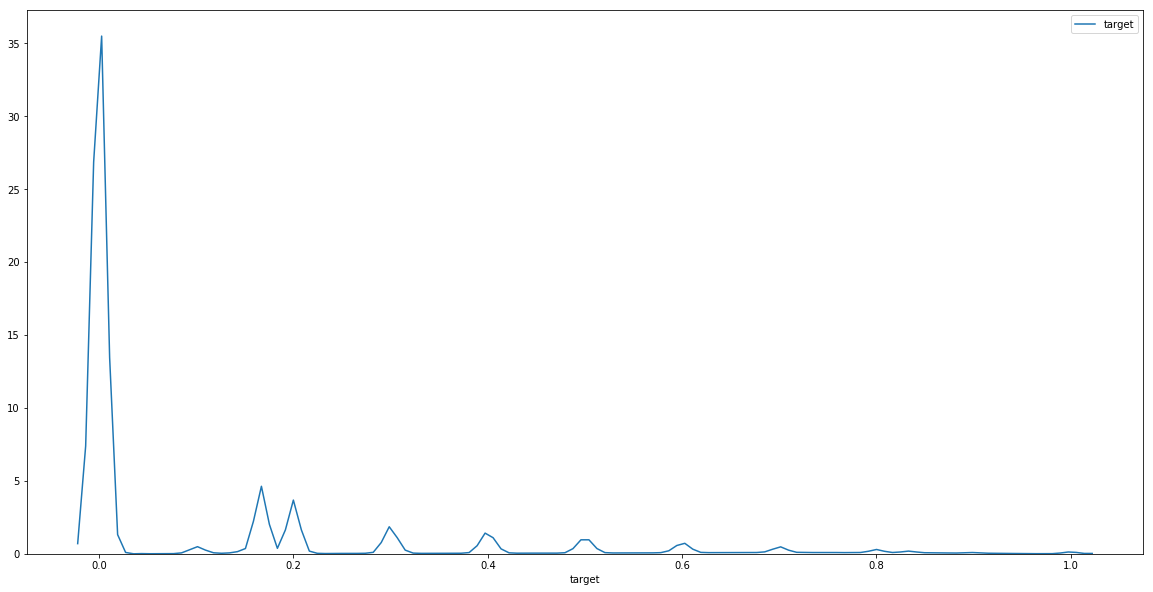

In [29]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['target'], hist=False, label='target')
plt.show()

Plot all toxic features. Insult seems the most common

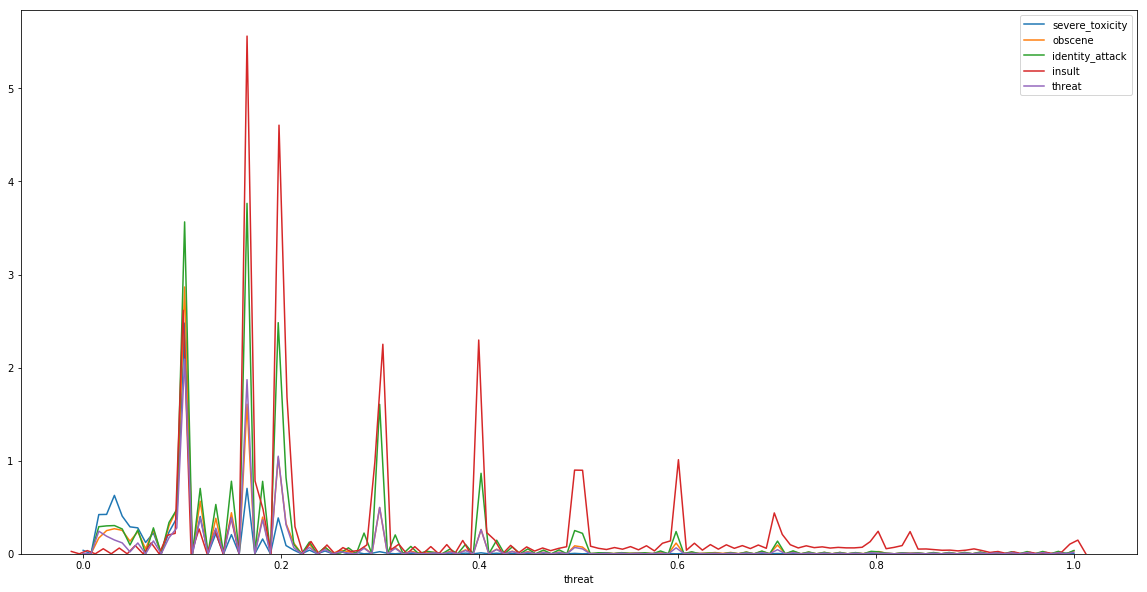

In [31]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['severe_toxicity'], hist=False, label='severe_toxicity')
sns.distplot(train_data['obscene'], hist=False, label='obscene')
sns.distplot(train_data['identity_attack'], hist=False, label='identity_attack')
sns.distplot(train_data['insult'], hist=False, label='insult')
sns.distplot(train_data['threat'], hist=False, label='threat')
plt.show()

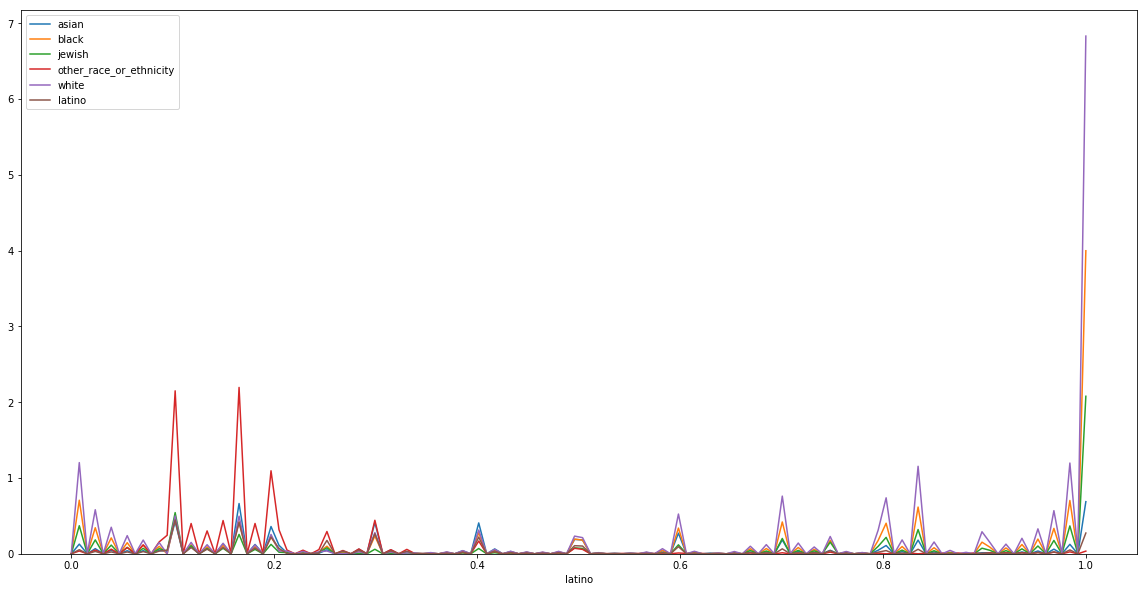

In [33]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['asian'], hist=False, label='asian')
sns.distplot(train_data['black'], hist=False, label='black')
sns.distplot(train_data['jewish'], hist=False, label='jewish')
sns.distplot(train_data['other_race_or_ethnicity'], hist=False, label='other_race_or_ethnicity')
sns.distplot(train_data['white'], hist=False, label='white')
sns.distplot(train_data['latino'], hist=False, label='latino')
plt.show()

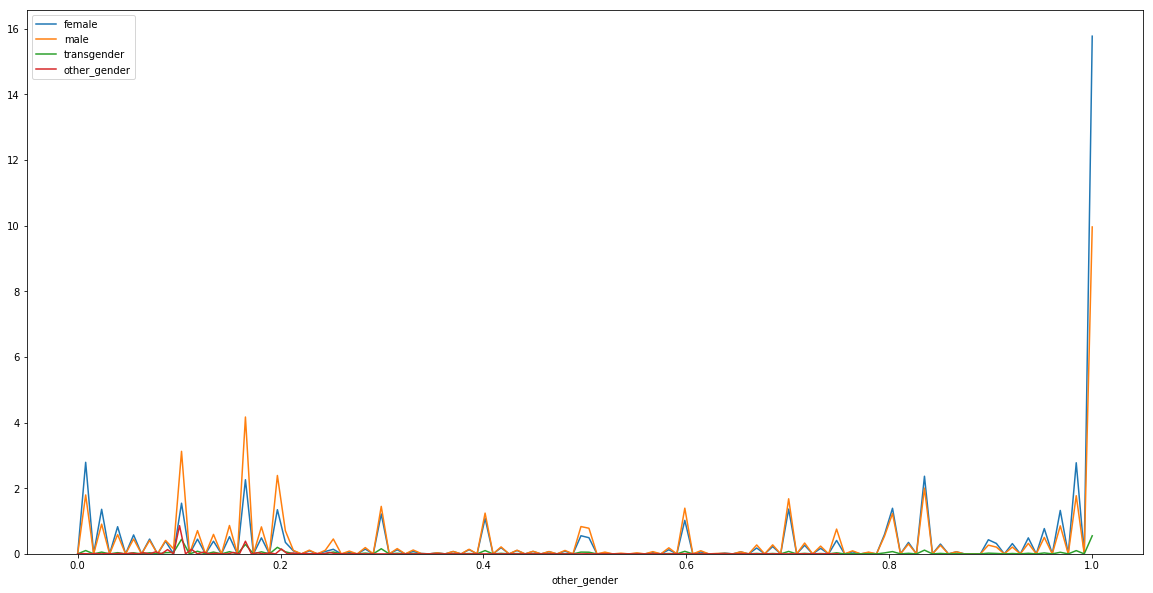

In [34]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['female'], hist=False, label='female')
sns.distplot(train_data['male'], hist=False, label='male')
sns.distplot(train_data['transgender'], hist=False, label='transgender')
sns.distplot(train_data['other_gender'], hist=False, label='other_gender')
plt.show()

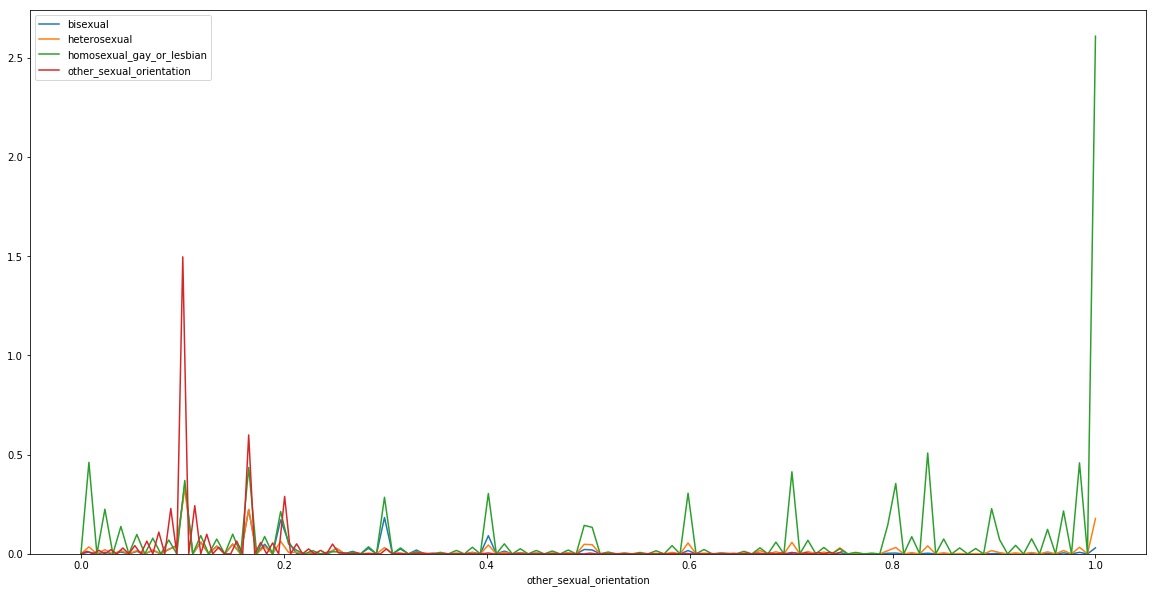

In [36]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['bisexual'], hist=False, label='bisexual')
sns.distplot(train_data['heterosexual'], hist=False, label='heterosexual')
sns.distplot(train_data['homosexual_gay_or_lesbian'], hist=False, label='homosexual_gay_or_lesbian')
sns.distplot(train_data['other_sexual_orientation'], hist=False, label='other_sexual_orientation')
plt.show()

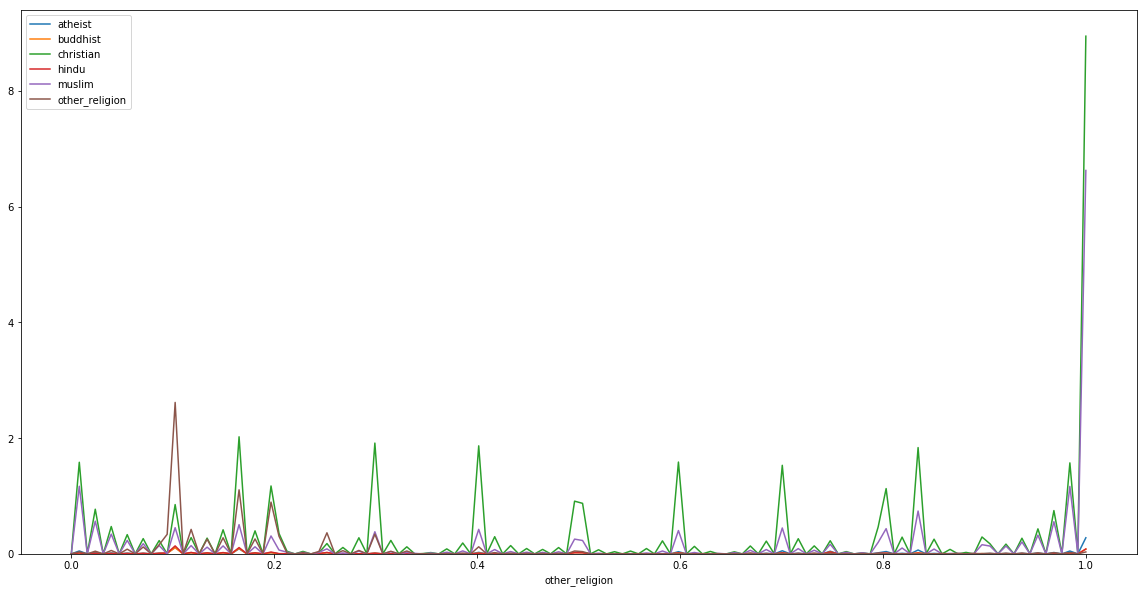

In [37]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['atheist'], hist=False, label='atheist')
sns.distplot(train_data['buddhist'], hist=False, label='buddhist')
sns.distplot(train_data['christian'], hist=False, label='christian')
sns.distplot(train_data['hindu'], hist=False, label='hindu')
sns.distplot(train_data['muslim'], hist=False, label='muslim')
sns.distplot(train_data['other_religion'], hist=False, label='other_religion')
plt.show()

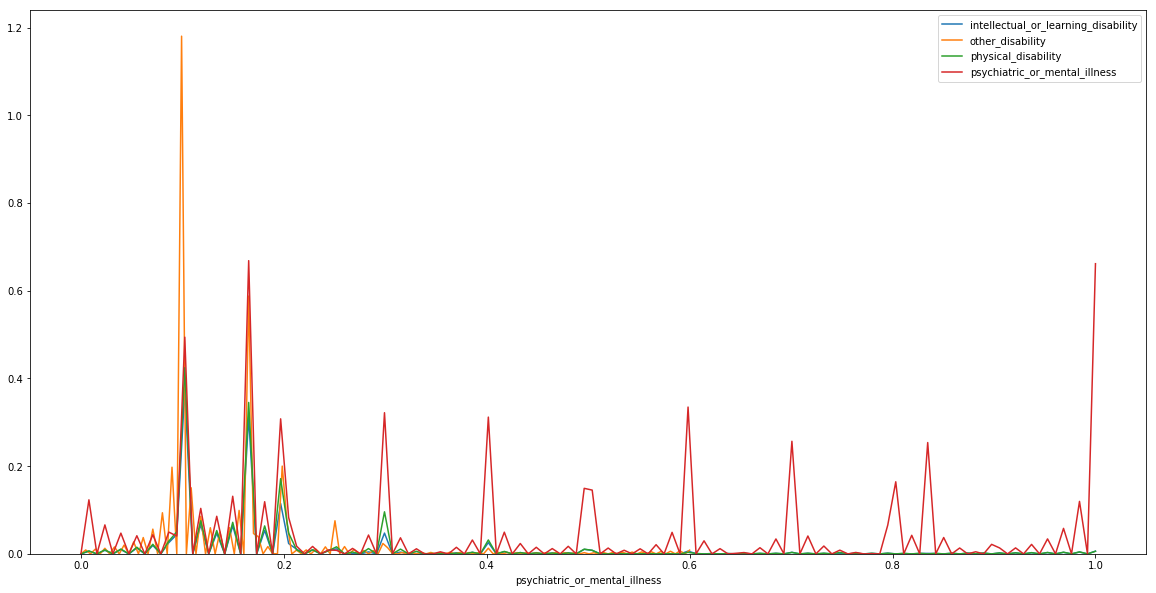

In [38]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['intellectual_or_learning_disability'], hist=False, label='intellectual_or_learning_disability')
sns.distplot(train_data['other_disability'], hist=False, label='other_disability')
sns.distplot(train_data['physical_disability'], hist=False, label='physical_disability')
sns.distplot(train_data['psychiatric_or_mental_illness'], hist=False, label='psychiatric_or_mental_illness')
plt.show()

In [45]:
train_data.rating.value_counts()

approved    1684758
rejected    120116 
Name: rating, dtype: int64

In [47]:
stopwords = set(STOPWORDS)

def wc(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=100,
        max_font_size=25, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

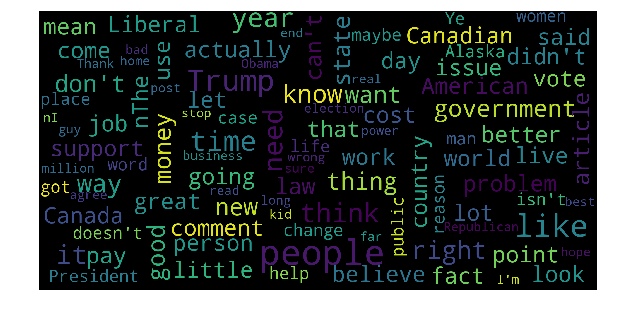

In [49]:
wc(train_data['comment_text'].sample(20000))

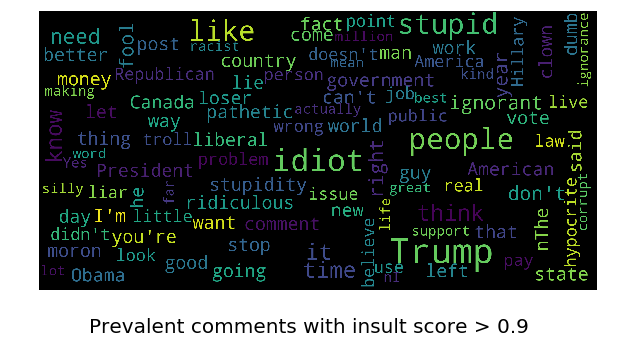

In [56]:
wc(train_data.loc[train_data['insult'] > 0.90]['comment_text'].sample(5000), 
               title = 'Prevalent comments with insult score > 0.9')

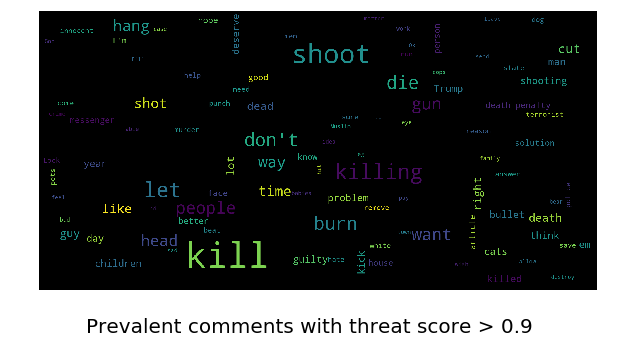

In [64]:
wc(train_data.loc[train_data['threat'] > 0.90]['comment_text'], 
               title = 'Prevalent comments with threat score > 0.9')

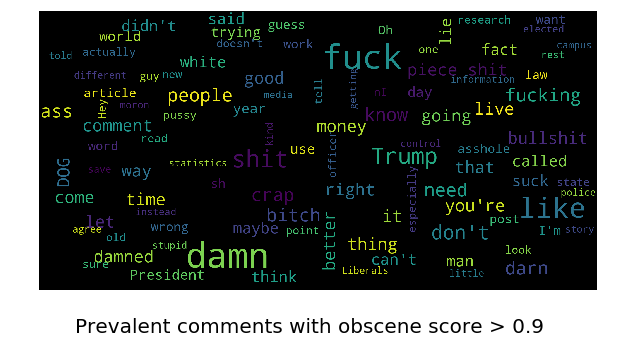

In [66]:
wc(train_data.loc[train_data['obscene'] > 0.90]['comment_text'], 
               title = 'Prevalent comments with obscene score > 0.9')

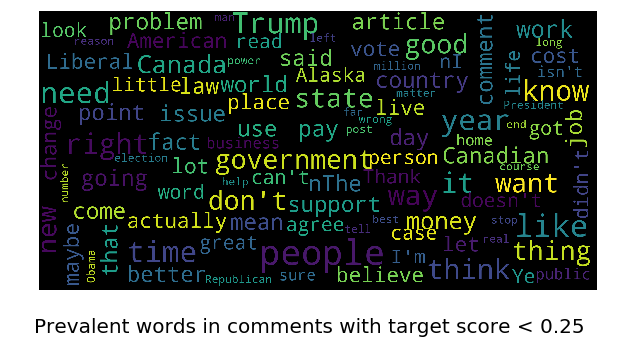

In [68]:
wc(train_data.loc[train_data['target'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent words in comments with target score < 0.25')

Let's use LDA (topic modeling)

In [69]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [70]:
preprocessed_comments = train_data['comment_text'].sample(200000).map(preprocess)

In [71]:
preprocessed_comments.sample(10)

id
1022197    [comfortable, good, selections, selected, business, successful, political, worked, years, constitution, ratification, long, president, trump, stays, obey, nominations, confirmations, friends, able, mike, flynn, enjoy, victory, opinion, better, worked, like, supposed, look, night, koch, brother]                                                                                                                                                                                
961204     [course, blind, nailed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                
5453472    [muslims, race, blac

In [85]:
dictionary = gensim.corpora.Dictionary(preprocessed_comments)

In [86]:
len(dictionary)

94030

In [87]:
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_comments]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [88]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20,
                                    id2word=dictionary, passes=2, workers=2)

In [89]:
topics = lda_model.print_topics(num_words=10)
for i, topic in enumerate(topics[:10]):
    print("Train topic {}: {}".format(i, topic))

Train topic 0: (0, '0.005*"game" + 0.004*"team" + 0.003*"play" + 0.003*"games" + 0.003*"like" + 0.003*"season" + 0.002*"bear" + 0.002*"good" + 0.002*"players" + 0.002*"trump"')
Train topic 1: (1, '0.005*"trump" + 0.005*"people" + 0.005*"right" + 0.004*"like" + 0.004*"white" + 0.003*"party" + 0.003*"know" + 0.003*"think" + 0.003*"vote" + 0.003*"women"')
Train topic 2: (2, '0.006*"church" + 0.004*"said" + 0.004*"comment" + 0.004*"like" + 0.003*"jesus" + 0.003*"comments" + 0.003*"post" + 0.003*"catholic" + 0.003*"trump" + 0.003*"people"')
Train topic 3: (3, '0.004*"thank" + 0.003*"climate" + 0.003*"agree" + 0.002*"science" + 0.002*"like" + 0.002*"warming" + 0.002*"lock" + 0.002*"change" + 0.002*"global" + 0.002*"cats"')
Train topic 4: (4, '0.004*"illegal" + 0.003*"people" + 0.003*"immigration" + 0.003*"legal" + 0.002*"police" + 0.002*"laws" + 0.002*"wage" + 0.002*"drugs" + 0.002*"drug" + 0.002*"immigrants"')
Train topic 5: (5, '0.008*"thanks" + 0.005*"exactly" + 0.005*"lisa" + 0.003*"dele

In [90]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [91]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.268449  0.031158  1       1        28.285616
1      0.252901 -0.037824  2       1        20.528343
2      0.166117 -0.092592  3       1        7.316298 
14     0.152266 -0.062376  4       1        6.959008 
4      0.150272  0.090321  5       1        5.886422 
3      0.114107  0.052251  6       1        4.569639 
8      0.075893  0.143649  7       1        3.819169 
0      0.078169 -0.012181  8       1        3.349962 
16     0.019209 -0.122754  9       1        2.682390 
9      0.026970 -0.074814  10      1        2.465988 
11    -0.057773  0.018842  11      1        1.867429 
19    -0.063957  0.130402  12      1        1.831331 
15    -0.120113  0.064233  13      1        1.488963 
17    -0.141886  0.076378  14      1        1.442052 
5     -0.108341 -0.067168  15      1        1.362346 
13    -0.146710  0.062180  16      1        1.344251 
6     -0.163550 -0.028800  17      1        1.227700 
12    -0.157420 -0.064399  18      1        1.212334 
10    -0.141610 -0.092371  19      1        1.203802 
7     -0.202994 -0.014134  20      1        1.156955 , topic_info=      Category          Freq             Term         Total  loglift  logprob
159    Default  13215.000000  trump            13215.000000  30.0000  30.0000
22     Default  8880.000000   good             8880.000000   29.0000  29.0000
544    Default  2815.000000   church           2815.000000   28.0000  28.0000
531    Default  1925.000000   watch            1925.000000   27.0000  27.0000
1093   Default  2449.000000   thanks           2449.000000   26.0000  26.0000
187    Default  5191.000000   president        5191.000000   25.0000  25.0000
1214   Default  2057.000000   russia           2057.000000   24.0000  24.0000
568    Default  4302.000000   news             4302.000000   23.0000  23.0000
611    Default  2627.000000   exactly          2627.000000   22.0000  22.0000
530    Default  1790.000000   https            1790.000000   21.0000  21.0000
650    Default  3991.000000   wrong            3991.000000   20.0000  20.0000
1080   Default  4155.000000   obama            4155.000000   19.0000  19.0000
293    Default  3838.000000   comment          3838.000000   18.0000  18.0000
2851   Default  2908.000000   clinton          2908.000000   17.0000  17.0000
756    Default  4033.000000   read             4033.000000   16.0000  16.0000
18     Default  4028.000000   taxes            4028.000000   15.0000  15.0000
7180   Default  1574.000000   russian          1574.000000   14.0000  14.0000
2640   Default  2117.000000   illegal          2117.000000   13.0000  13.0000
1785   Default  1963.000000   fake             1963.000000   12.0000  12.0000
1843   Default  1921.000000   game             1921.000000   11.0000  11.0000
74     Default  2999.000000   hillary          2999.000000   10.0000  10.0000
92     Default  12018.000000  like             12018.000000  9.0000   9.0000 
1571   Default  1084.000000   muslim           1084.000000   8.0000   8.0000 
194    Default  4210.000000   article          4210.000000   7.0000   7.0000 
724    Default  1390.000000   religion         1390.000000   6.0000   6.0000 
345    Default  3127.000000   income           3127.000000   5.0000   5.0000 
1572   Default  976.000000    muslims          976.000000    4.0000   4.0000 
110    Default  1645.000000   climate          1645.000000   3.0000   3.0000 
445    Default  4751.000000   sure             4751.000000   2.0000   2.0000 
235    Default  4545.000000   point            4545.000000   1.0000   1.0000 
5074   Topic1   799.125122    pension          803.294495    1.2576  -7.3218 
9419   Topic1   710.212769    medicare         713.987793    1.2575  -7.4398 
2250   Topic1   675.563965    medicaid         679.340698    1.2572  -7.4898 
1487   Topic1   610.910461    credits          614.791260    1.2565  -7.5904 
3897   Topic1   525.666443    payments 

Same thing but for the test data

In [92]:
preprocessed_comments = test_dataataataataataata_data_data_data_data_data_data_data_data_data_data['comment_text'].map(preprocess)
dictionary = gensim.corpora.Dictionary(preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_comments]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [93]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20,
                                    id2word=dictionary, passes=2, workers=2)

In [94]:
topics = lda_model.print_topics(num_words=5)
for i, topic in enumerate(topics[:10]):
    print("Test topic {}: {}".format(i, topic))

Test topic 0: (0, '0.006*"money" + 0.005*"state" + 0.004*"government" + 0.004*"taxes" + 0.004*"people"')
Test topic 1: (1, '0.007*"good" + 0.006*"team" + 0.006*"game" + 0.005*"year" + 0.005*"time"')
Test topic 2: (2, '0.006*"income" + 0.005*"taxes" + 0.004*"cool" + 0.003*"money" + 0.003*"higher"')
Test topic 3: (3, '0.005*"trump" + 0.003*"mahalo" + 0.003*"bernstein" + 0.003*"yeah" + 0.003*"people"')
Test topic 4: (4, '0.006*"israel" + 0.004*"muslims" + 0.003*"minister" + 0.003*"hilarious" + 0.003*"sheep"')
Test topic 5: (5, '0.012*"news" + 0.008*"fake" + 0.007*"trump" + 0.006*"thanks" + 0.006*"post"')
Test topic 6: (6, '0.004*"drug" + 0.004*"drugs" + 0.004*"people" + 0.004*"traffic" + 0.004*"star"')
Test topic 7: (7, '0.011*"thank" + 0.006*"mean" + 0.004*"nice" + 0.004*"nope" + 0.004*"saudi"')
Test topic 8: (8, '0.004*"right" + 0.004*"people" + 0.004*"trump" + 0.003*"rights" + 0.003*"abortion"')
Test topic 9: (9, '0.005*"trump" + 0.005*"people" + 0.003*"like" + 0.003*"police" + 0.003*"

In [95]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [96]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.142837  0.025309  1       1        17.667171
9     -0.040989  0.051232  2       1        11.212273
8     -0.019978  0.066419  3       1        8.430229 
15     0.020229  0.059957  4       1        6.764200 
1      0.060762  0.051570  5       1        6.335016 
13    -0.152622  0.105820  6       1        6.041787 
5     -0.063503  0.038912  7       1        5.013098 
18     0.032537  0.041360  8       1        4.101757 
6      0.068096  0.002775  9       1        3.545497 
2      0.156326 -0.006936  10      1        3.497047 
12    -0.062217  0.043630  11      1        3.307976 
17     0.064117 -0.049147  12      1        3.145183 
14    -0.079143  0.018608  13      1        2.998661 
11     0.000874  0.003083  14      1        2.914920 
10     0.111379 -0.016515  15      1        2.880239 
16    -0.010908 -0.001927  16      1        2.879096 
3     -0.001017  0.005271  17      1        2.832360 
19    -0.081390 -0.076950  18      1        2.305000 
7      0.012941 -0.238553  19      1        2.095322 
4     -0.158330 -0.123919  20      1        2.033173 , topic_info=      Category         Freq             Term        Total  loglift  logprob
925    Default  1237.000000  church           1237.000000  30.0000  30.0000
834    Default  1808.000000  income           1808.000000  29.0000  29.0000
12     Default  6281.000000  trump            6281.000000  28.0000  28.0000
755    Default  1789.000000  thank            1789.000000  27.0000  27.0000
139    Default  2322.000000  news             2322.000000  26.0000  26.0000
1236   Default  2069.000000  taxes            2069.000000  25.0000  25.0000
137    Default  1137.000000  fake             1137.000000  24.0000  24.0000
923    Default  827.000000   catholic         827.000000   23.0000  23.0000
479    Default  806.000000   jesus            806.000000   22.0000  22.0000
966    Default  885.000000   insurance        885.000000   21.0000  21.0000
551    Default  1077.000000  team             1077.000000  20.0000  20.0000
1282   Default  1478.000000  health           1478.000000  19.0000  19.0000
2094   Default  1279.000000  game             1279.000000  18.0000  18.0000
765    Default  773.000000   religion         773.000000   17.0000  17.0000
791    Default  519.000000   pope             519.000000   16.0000  16.0000
783    Default  1329.000000  https            1329.000000  15.0000  15.0000
445    Default  2270.000000  vote             2270.000000  14.0000  14.0000
2684   Default  497.000000   bishops          497.000000   13.0000  13.0000
302    Default  3266.000000  canada           3266.000000  12.0000  12.0000
213    Default  2110.000000  party            2110.000000  11.0000  11.0000
171    Default  5942.000000  like             5942.000000  10.0000  10.0000
1338   Default  1768.000000  election         1768.000000  9.0000   9.0000 
3739   Default  420.000000   troll            420.000000   8.0000   8.0000 
1932   Default  665.000000   season           665.000000   7.0000   7.0000 
1793   Default  734.000000   religious        734.000000   6.0000   6.0000 
1556   Default  1645.000000  thanks           1645.000000  5.0000   5.0000 
284    Default  4869.000000  good             4869.000000  4.0000   4.0000 
670    Default  791.000000   debt             791.000000   3.0000   3.0000 
216    Default  1038.000000  russia           1038.000000  2.0000   2.0000 
1142   Default  1716.000000  mean             1716.000000  1.0000   1.0000 
5346   Topic1   370.362854   emissions        375.355133   1.7201  -6.8406 
2249   Topic1   204.628922   basement         209.615860   1.7094  -7.4339 
2735   Topic1   185.030762   loaded           189.666245   1.7087  -7.5346 
3296   Topic1   234.570145   airline          240.756699   1.7074  -7.2974 
5222   Topic1   198.611908   buses            204.044998   1.7065  -7.4638 
7790   Topic1   164.169876   harr